<a href="https://colab.research.google.com/github/AminFathollahi/NMA_DL/blob/main/tutorials/W2D2_NeuroSymbolicMethods/student/W2D2_Tutorial2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tutorial 2: Learning with structure

**Week 2, Day 2: Neuro-Symbolic Methods**

**By Neuromatch Academy**

__Content creators:__ P. Michael Furlong, Chris Eliasmith

__Content reviewers:__ Hlib Solodzhuk, Patrick Mineault, Aakash Agrawal, Alish Dipani, Hossein Rezaei, Yousef Ghanbari, Mostafa Abdollahi, Alex Murphy

__Production editors:__ Konstantine Tsafatinos, Ella Batty, Spiros Chavlis, Samuele Bolotta, Hlib Solodzhuk, Alex Murphy


___


# Tutorial Objectives

*Estimated timing of tutorial: 20 minutes*

This tutorial will present you with a couple of play-examples on the usage of basic operations of vector symbolic algebras while generalizing to the new knowledge.

In [ ]:
# @title Tutorial slides
# @markdown These are the slides for the videos in all tutorials today

from IPython.display import IFrame
link_id = "jybuw"

print(f"If you want to download the slides: 'https://osf.io/download/{link_id}'")

IFrame(src=f"https://mfr.ca-1.osf.io/render?url=https://osf.io/download/{link_id}/?direct%26mode=render", width=854, height=480)

---
# Setup (Colab Users: Please Read)

Note that because this tutorial relies on some special Python packages, these packages have requirements for specific versions of common scientific libraries, such as `numpy`. If you're in Google Colab, then as of May 2025, this comes with a later version (2.0.2) pre-installed. We require an older version (we'll be installing `1.24.4`). This causes Colab to force a session restart and then re-running of the installation cells for the new version to take effect. When you run the cell below, you will be prompted to restart the session. This is *entirely expected* and you haven't done anything wrong. Simply click 'Restart' and then run the cells as normal.

An additional error might sometimes arise where an exception is raised connected to a missing element of NumPy. If this occurs, please restart the session and re-run the cells as normal and this error will go away. Updated versions of the affected libraries are expected out soon, but sadly not in time for the preparation of this material. We thank you for your understanding.

In [1]:
# @title Install dependencies

!pip install numpy==1.24.4 --quiet
!pip install scikit-learn==1.6.1 --quiet
!pip install scipy==1.15.3 --quiet
!pip install git+https://github.com/neuromatch/sspspace@neuromatch --no-deps --quiet
!pip install nengo==4.0.0 --quiet
!pip install nengo_spa==2.0.0 --quiet
!pip install --quiet matplotlib ipywidgets vibecheck

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 34.7 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
jaxlib 0.5.1 requires numpy>=1.25, but you have numpy 1.24.4 which is incompatible.
blosc2 3.6.1 requires numpy>=1.26, but you have numpy 1.24.4 which is incompatible.
opencv-python-headless 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.24.4 which is incompatible.
jax 0.5.2 requires numpy>=1.25, but you have numpy 1.24.4 which is incompatible.
xarray-einstats 0.9.1 requires numpy>=1.25, but you have numpy 1.24.4 which is incompatible.
pymc 5.24.0 requires numpy>=1.25.0, but you have numpy 1.24.4 which is incompatible.
treescope 0.1.9 requires numpy>=1.25.2, but you have numpy 1.24.4 which is incompatible.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.24.4 which is incompatible.
tensor

In [1]:
# @title Install and import feedback gadget

from vibecheck import DatatopsContentReviewContainer
def content_review(notebook_section: str):
    return DatatopsContentReviewContainer(
        "",  # No text prompt
        notebook_section,
        {
            "url": "https://pmyvdlilci.execute-api.us-east-1.amazonaws.com/klab",
            "name": "neuromatch_neuroai",
            "user_key": "wb2cxze8",
        },
    ).render()


feedback_prefix = "W2D2_T2"

In [2]:
# @title Imports

#working with data
import numpy as np

#plotting
import matplotlib.pyplot as plt
import logging

#interactive display
import ipywidgets as widgets

#modeling
import sspspace
from scipy.special import softmax
from sklearn.metrics import log_loss
from sklearn.neural_network import MLPRegressor

import nengo_spa as spa
from nengo_spa.algebras.hrr_algebra import HrrProperties, HrrAlgebra
from nengo_spa.vector_generation import VectorsWithProperties
def make_vocabulary(vector_length):
    vec_generator = VectorsWithProperties(vector_length, algebra=HrrAlgebra(), properties = [HrrProperties.UNITARY, HrrProperties.POSITIVE])
    vocab = spa.Vocabulary(vector_length, pointer_gen=vec_generator)
    return vocab

In [3]:
# @title Figure settings

logging.getLogger('matplotlib.font_manager').disabled = True

%matplotlib inline
%config InlineBackend.figure_format = 'retina' # perfrom high definition rendering for images and plots
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/main/nma.mplstyle")

In [4]:
# @title Plotting functions

def plot_similarity_matrix(sim_mat, labels, values = False):
    """
    Plot the similarity matrix between vectors.

    Inputs:
    - sim_mat (numpy.ndarray): similarity matrix between vectors.
    - labels (list of str): list of strings which represent concepts.
    - values (bool): True if we would like to plot values of similarity too.
    """
    with plt.xkcd():
        plt.imshow(sim_mat, cmap='Greys')
        plt.colorbar()
        plt.xticks(np.arange(len(labels)), labels, rotation=45, ha="right", rotation_mode="anchor")
        plt.yticks(np.arange(len(labels)), labels)
        if values:
            for x in range(sim_mat.shape[1]):
                for y in range(sim_mat.shape[0]):
                    plt.text(x, y, f"{sim_mat[y, x]:.2f}", fontsize = 8, ha="center", va="center", color="green")
        plt.title('Similarity between vector-symbols')
        plt.xlabel('Symbols')
        plt.ylabel('Symbols')
        plt.show()

def plot_training_and_choice(losses, sims, ant_names, cons_names, action_names):
    """
    Plot loss progression over training as well as predicted similarities for given rules / correct solutions.

    Inputs:
    - losses (list): list of loss values.
    - sims (list): list of similartiy matrices.
    - ant_names (list): list of antecedance names.
    - cons_names (list): list of consequent names.
    - action_names (list): full list of concepts.
    """
    with plt.xkcd():
        plt.subplot(1, len(ant_names) + 1, 1)
        plt.plot(losses)
        plt.xlabel('Training number')
        plt.ylabel('Loss')
        plt.title('Training Error')
        index = 1
        for ant_name, cons_name, sim in zip(ant_names, cons_names, sims):
            index += 1
            plt.subplot(1, len(ant_names) + 1, index)
            plt.bar(range(len(action_names)), sim.flatten())
            plt.gca().set_xticks(range(len(action_names)))
            plt.gca().set_xticklabels(action_names, rotation=90)
            plt.title(f'{ant_name}, not*{cons_name}')

def plot_choice(sims, ant_names, cons_names, action_names):
    """
    Plot predicted similarities for given rules / correct solutions.
    """
    with plt.xkcd():
        index = 0
        for ant_name, cons_name, sim in zip(ant_names, cons_names, sims):
            index += 1
            plt.subplot(1, len(ant_names) + 1, index)
            plt.bar(range(len(action_names)), sim.flatten())
            plt.gca().set_xticks(range(len(action_names)))
            plt.gca().set_xticklabels(action_names, rotation=90)
            plt.ylabel("Similarity")
            plt.title(f'{ant_name}, not*{cons_name}')

In [5]:
# @title Set random seed

import random
import numpy as np

def set_seed(seed=None):
  if seed is None:
    seed = np.random.choice(2 ** 32)
  random.seed(seed)
  np.random.seed(seed)

set_seed(seed = 42)

In [6]:
# @title Helper functions

set_seed(42)

symbol_names = ['monarch','heir','male','female']
discrete_space = sspspace.DiscreteSPSpace(symbol_names, ssp_dim=1024, optimize=False)

objs = {n:discrete_space.encode(n) for n in symbol_names}

objs['king'] = objs['monarch'] * objs['male']
objs['queen'] = objs['monarch'] * objs['female']
objs['prince'] = objs['heir'] * objs['male']
objs['princess'] = objs['heir'] * objs['female']

bundle_objs = {n:discrete_space.encode(n) for n in symbol_names}

bundle_objs['king'] = (bundle_objs['monarch'] + bundle_objs['male']).normalize()
bundle_objs['queen'] = (bundle_objs['monarch'] + bundle_objs['female']).normalize()
bundle_objs['prince'] = (bundle_objs['heir'] + bundle_objs['male']).normalize()
bundle_objs['princess'] = (bundle_objs['heir'] + bundle_objs['female']).normalize()

bundle_objs['princess_query'] = (bundle_objs['prince'] - bundle_objs['king']) + bundle_objs['queen']

new_symbol_names = ['dollar', 'peso', 'ottawa', 'mexico-city', 'currency', 'capital']
new_discrete_space = sspspace.DiscreteSPSpace(new_symbol_names, ssp_dim=1024, optimize=False)

new_objs = {n:new_discrete_space.encode(n) for n in new_symbol_names}

cleanup = sspspace.Cleanup(new_objs)

new_objs['canada'] = ((new_objs['currency'] * new_objs['dollar']) + (new_objs['capital'] * new_objs['ottawa'])).normalize()
new_objs['mexico'] = ((new_objs['currency'] * new_objs['peso']) + (new_objs['capital'] * new_objs['mexico-city'])).normalize()

card_states = ['red','blue','odd','even','not','green','prime','implies','ant','relation','cons']
encoder = sspspace.DiscreteSPSpace(card_states, ssp_dim=1024, optimize=False)
vocab = {c:encoder.encode(c) for c in card_states}

for a in ['red','blue','odd','even','green','prime']:
    vocab[f'not*{a}'] = vocab['not'] * vocab[a]

action_names = ['red','blue','odd','even','green','prime','not*red','not*blue','not*odd','not*even','not*green','not*prime']
action_space = np.array([vocab[x] for x in action_names]).squeeze()

rules = [
    (vocab['ant'] * vocab['blue'] + vocab['relation'] * vocab['implies'] + vocab['cons'] * vocab['even']).normalize(),
    (vocab['ant'] * vocab['odd'] + vocab['relation'] * vocab['implies'] + vocab['cons'] * vocab['green']).normalize(),
]

---

# Section 1: Wason Card Task

One of the powerful benefits of using these structured representations is being able to generalize to other circumstances. To demonstrate this, we are going to show you this in a simple task.

In [8]:
# @title Video 1: Wason Card Task Intro

from ipywidgets import widgets
from IPython.display import YouTubeVideo
from IPython.display import IFrame
from IPython.display import display

class PlayVideo(IFrame):
  def __init__(self, id, source, page=1, width=400, height=300, **kwargs):
    self.id = id
    if source == 'Bilibili':
      src = f'https://player.bilibili.com/player.html?bvid={id}&page={page}'
    elif source == 'Osf':
      src = f'https://mfr.ca-1.osf.io/render?url=https://osf.io/download/{id}/?direct%26mode=render'
    super(PlayVideo, self).__init__(src, width, height, **kwargs)

def display_videos(video_ids, W=400, H=300, fs=1):
  tab_contents = []
  for i, video_id in enumerate(video_ids):
    out = widgets.Output()
    with out:
      if video_ids[i][0] == 'Youtube':
        video = YouTubeVideo(id=video_ids[i][1], width=W,
                             height=H, fs=fs, rel=0)
        print(f'Video available at https://youtube.com/watch?v={video.id}')
      else:
        video = PlayVideo(id=video_ids[i][1], source=video_ids[i][0], width=W,
                          height=H, fs=fs, autoplay=False)
        if video_ids[i][0] == 'Bilibili':
          print(f'Video available at https://www.bilibili.com/video/{video.id}')
        elif video_ids[i][0] == 'Osf':
          print(f'Video available at https://osf.io/{video.id}')
      display(video)
    tab_contents.append(out)
  return tab_contents

video_ids = [('Youtube', 'BAju3MNHCq8'), ('Bilibili', 'BV1Qf421X7MB')]
tab_contents = display_videos(video_ids, W=854, H=480)
tabs = widgets.Tab()
tabs.children = tab_contents
for i in range(len(tab_contents)):
  tabs.set_title(i, video_ids[i][0])
display(tabs)

In [ ]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_wason_card_task_intro")

## Coding Exercise 1: Wason Card Task

We are going to test the generalization property on the Wason Card Task, where a person is told a rule of the form "if the card is even, then the back is blue", they are then presented with a number of cards with either an odd number, an even number, a red back, or a blue back. The participant is asked which cards they have to flip to determine that the rule is true.

In this case, the participant needs to flip only the even card(s), and any card where the back is not blue, as the rule does not state whether or not odd numbers can have blue backs, and a red-backed card with an even number would violate the rule.  We can get this from Boolean logic:

$$
\mathrm{even} \implies \mathrm{blue}
$$

which is equal to

$$
\neg \mathrm{even} \vee \mathrm{blue}
$$

where $\neg$ means a logical not.  If we want to find cards that violate the rule, then we negate the rule, providing:

$$
\neg (\neg \mathrm{even} \vee \mathrm{blue}) = \mathrm{even} \wedge \neg \mathrm{blue}.
$$

Hence the cards that can violate the rule are even and not blue.  

At first, we will define all needed concepts. For all noun concepts we would also like to have `not concept` presented in the space, please complete missing code parts.

In [9]:
set_seed(42)
vector_length = 1024

card_states = ['RED','BLUE','ODD','EVEN','NOT','GREEN','PRIME','IMPLIES','ANT','RELATION','CONS']
vocab = make_vocabulary(vector_length)
vocab.populate(';'.join(card_states))

###################################################################
## Fill out the following then remove
# raise NotImplementedError("Student exercise: complete creating `not x` concepts.")
###################################################################

for a in ['RED','BLUE','ODD','EVEN','GREEN','PRIME']:
    vocab.add(f'NOT_{a}', vocab['NOT'] * vocab[a])

action_names = ['RED','BLUE','ODD','EVEN','GREEN','PRIME','NOT_RED','NOT_BLUE','NOT_ODD','NOT_EVEN','NOT_GREEN','NOT_PRIME']
action_space = np.array([vocab[x].v for x in action_names]).squeeze()

[*Click for solution*](https://github.com/neuromatch/NeuroAI_Course/tree/main/tutorials/W2D2_NeuroSymbolicMethods/solutions/W2D2_Tutorial2_Solution_a0e39449.py)



Now, we are going to set up a simple perceptron-style learning rule, using the HRR (Holographic Reduced Representations) algebra.  We are going to learn a target transformation, $T$, such that given a learning rule, $A^{*} = T\circledast R$, where $A^{*}$ is the antecedant value bundled with $\texttt{not}$ bound with the consequent value, because we are trying to learn the cards that can violate the rule, described above, and $R$ is the rule to be learned.

Rules themselves are going to be composed like the data structures representing different countries in the previous section. `ant`, `relation` and `cons` are extra concepts which define the structure and which will bind to the specific instances.

If we have a rule, $X \implies Y$, then we would create the VSA representation:

$$R = \texttt{ant}\circledast X + \texttt{relation}\circledast \text{implies} + \texttt{cons} \circledast Y$$,

and the ideal output is:

$$
A^{*} = X + \texttt{not}\circledast Y
$$




In the cell below, let us define two rules:

$$\text{blue} \implies \text{even}$$
$$\text{odd} \implies \text{green}$$

In [10]:
###################################################################
## Fill out the following then remove
# raise NotImplementedError("Student exercise: complete creating rules as defined above.")
###################################################################

rules = [
    (vocab['ANT'] * vocab['BLUE'] + vocab['RELATION'] * vocab['IMPLIES'] + vocab['CONS'] * vocab['EVEN']).normalized(),
    (vocab['ANT'] * vocab['GREEN'] + vocab['RELATION'] * vocab['IMPLIES'] + vocab['CONS'] * vocab['ODD']).normalized(),
]

[*Click for solution*](https://github.com/neuromatch/NeuroAI_Course/tree/main/tutorials/W2D2_NeuroSymbolicMethods/solutions/W2D2_Tutorial2_Solution_bab79b64.py)



Now, we are ready to derive the transformation! For that, we will iterate through the rules and solutions for specified number of iterations and update it as the following:

$$\Delta T \leftarrow T - \text{lr}*(A^{*} \circledast \sim R)$$

where $\text{lr}$ is learning rate constant value. Ultimately, we want $A^{*} = T\circledast R$, so we unbind $R$ to recorver the desired transform, and use the learning rule to update our current estimated transform.

We will also compute loss progression over the time and log loss function between perfect similarity (ones only for antecedance value and not consequent one) and the one we obtain between prediciton for current transformation and full action space. Complete missing parts of the code in the next cell to complete training.

In [17]:
###################################################################
## Fill out the following then remove
# raise NotImplementedError("Student exercise: complete training loop.")
###################################################################

num_iters = 500
losses = []
sims = []
lr = 1e-1
ant_names = ["BLUE", "ODD"]
cons_names = ["EVEN", "GREEN"]
vector_length = 1024

transform = np.zeros((vector_length))
for i in range(num_iters):
    loss = 0
    for rule, ant_name, cons_name in zip(rules, ant_names, cons_names):

        #perfect similarity
        y_true = np.eye(len(action_names))[action_names.index(ant_name),:] + np.eye(len(action_names))[4+action_names.index(cons_name),:]

        #prediction with current transform (a_hat = transform * rule)
        a_hat = spa.SemanticPointer(transform) * rule

        #similarity with current transform
        sim_mat = np.einsum('nd,d->n', action_space, a_hat.v)

        #cleanup
        y_hat = softmax(sim_mat)

        #true solution (a* = ant_name + not * cons_name)
        a_true = (vocab[ant_name] + vocab['NOT']*vocab[cons_name]).normalized()

        #calculate loss
        loss += log_loss(y_true, y_hat)

        #update transform (T <- T - lr * (A* * (~rule)))
        transform -= (lr) * (transform -(a_true * ~rule).v)
        transform = transform / np.linalg.norm(transform)

        #save predicted similarities if it is last iteration
        if i == num_iters - 1:
            sims.append(sim_mat)

    #save loss
    losses.append(np.copy(loss))

[*Click for solution*](https://github.com/neuromatch/NeuroAI_Course/tree/main/tutorials/W2D2_NeuroSymbolicMethods/solutions/W2D2_Tutorial2_Solution_550fd076.py)



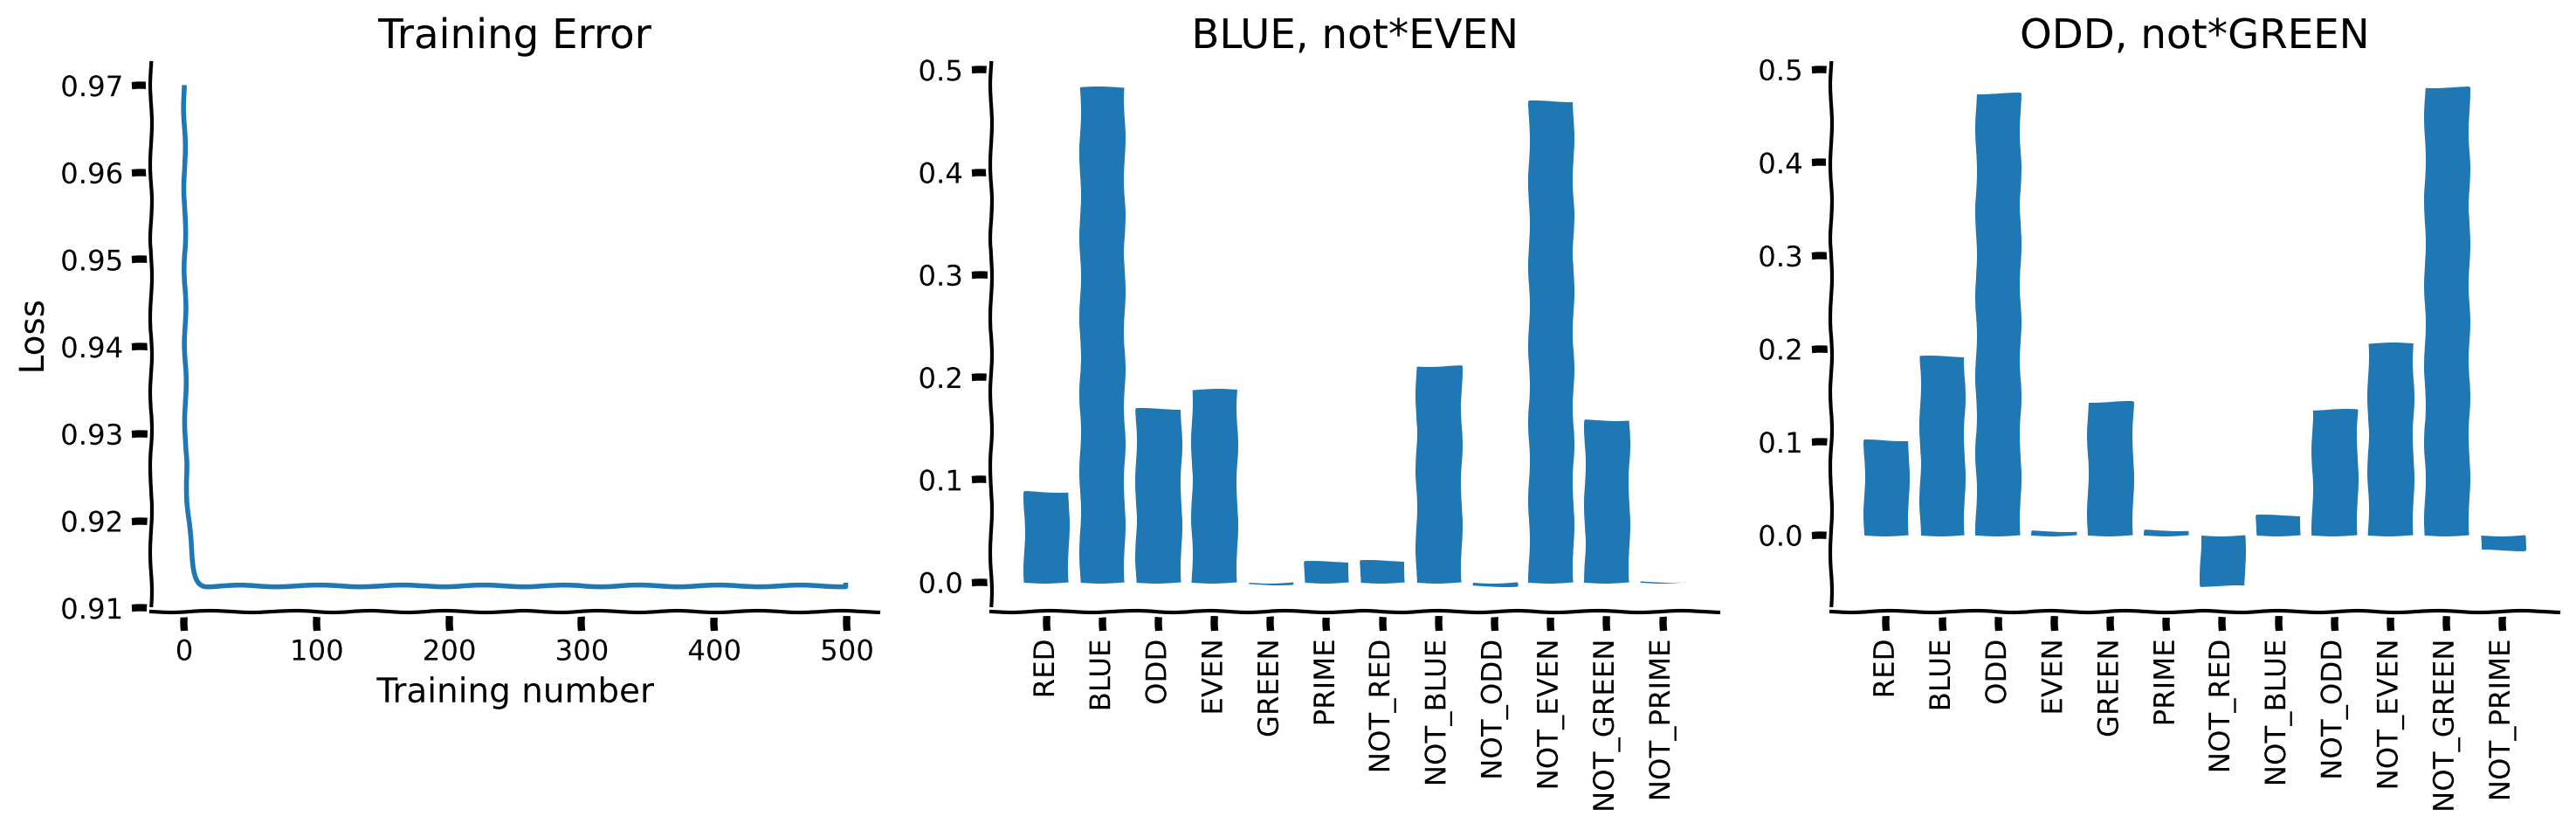

In [18]:
plt.figure(figsize=(15,5))
plot_training_and_choice(losses, sims, ant_names, cons_names, action_names)

Let's see what happens when we test it on a new rule it hasn't seen before. This time we will use the rule that $\text{red} \implies \text{prime}$. Your task is to complete new rule in the cell below and observe the results.

In [30]:

new_rule = (vocab['ANT'] * vocab['RED'] + vocab['RELATION'] * vocab['IMPLIES'] + vocab['CONS'] * vocab['PRIME']).normalized()

#apply transform on new rule to test the generalization of the transform
a_hat = spa.SemanticPointer(transform) * new_rule

new_sims = np.einsum('nd,d->n', action_space, a_hat.v)
y_hat = softmax(new_sims)

[*Click for solution*](https://github.com/neuromatch/NeuroAI_Course/tree/main/tutorials/W2D2_NeuroSymbolicMethods/solutions/W2D2_Tutorial2_Solution_3a819ce6.py)



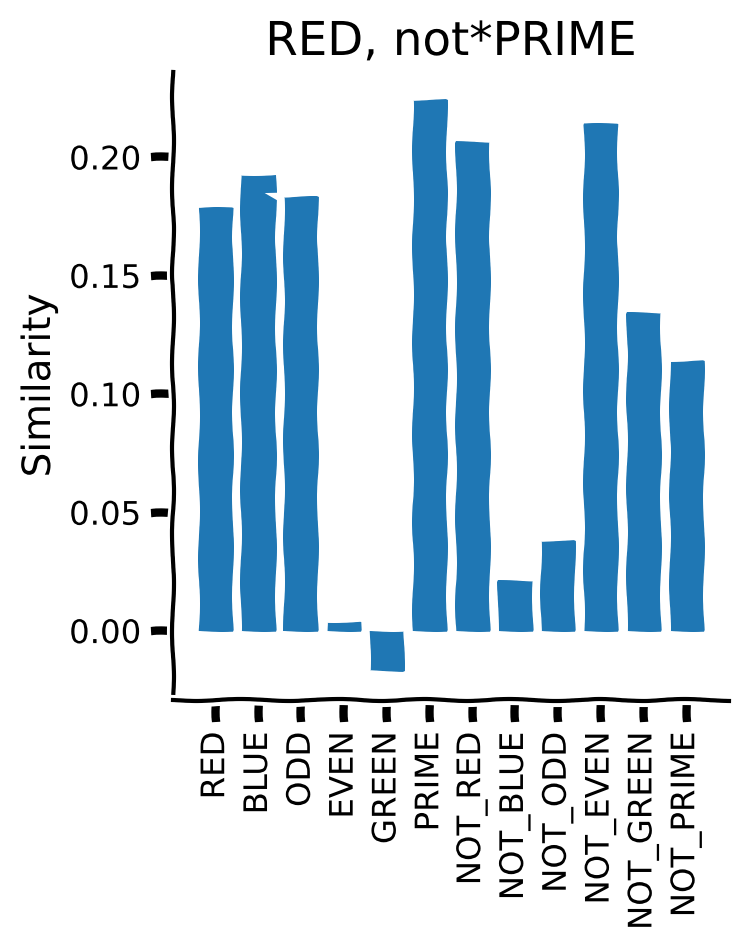

In [31]:
plt.figure(figsize=(7,5))
plot_choice([new_sims], ["RED"], ["PRIME"], action_names)

Let's compare how a standard MLP that isn't aware of the structure in the representation performs. Here, features are going to be the rules and output - solutions. Complete the code below.

In [28]:
###################################################################
# # Fill out the following then remove
# raise NotImplementedError("Student exercise: complete MLP training.")
###################################################################

#features - rules
X_train = np.array([r.v for r in rules]).squeeze()

#output - a* for each rule
y_train = np.array([
    (vocab[ant_names[0]] + vocab['NOT']*vocab[cons_names[0]]).normalized().v,
    (vocab[ant_names[1]] + vocab['NOT']*vocab[cons_names[1]]).normalized().v,
]).squeeze()

regr = MLPRegressor(random_state=1, hidden_layer_sizes=(1024,1024), max_iter=1000).fit(X_train, y_train)

a_mlp = regr.predict(new_rule.v[None,:])

mlp_sims = np.einsum('nd,md->nm', action_space, a_mlp)

[*Click for solution*](https://github.com/neuromatch/NeuroAI_Course/tree/main/tutorials/W2D2_NeuroSymbolicMethods/solutions/W2D2_Tutorial2_Solution_cc0b7eb5.py)



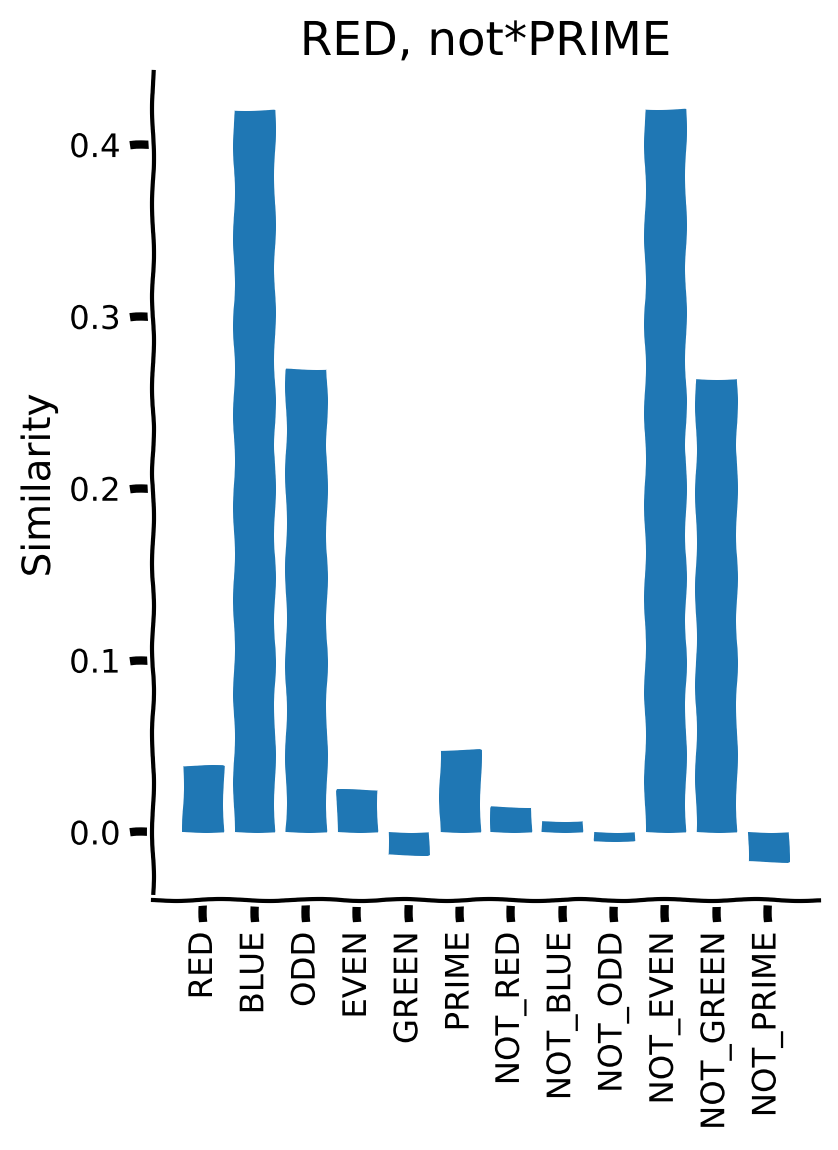

In [29]:
plot_choice([mlp_sims], ["RED"], ["PRIME"], action_names)

As you can see, this model, even though it is a more expressive neural network, simply learns to predict the values it had seen before when presented with a novel stimulus.

In [ ]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_wason_card_task")

In [ ]:
# @title Video 2: Wason Card Task Outro

from ipywidgets import widgets
from IPython.display import YouTubeVideo
from IPython.display import IFrame
from IPython.display import display

class PlayVideo(IFrame):
  def __init__(self, id, source, page=1, width=400, height=300, **kwargs):
    self.id = id
    if source == 'Bilibili':
      src = f'https://player.bilibili.com/player.html?bvid={id}&page={page}'
    elif source == 'Osf':
      src = f'https://mfr.ca-1.osf.io/render?url=https://osf.io/download/{id}/?direct%26mode=render'
    super(PlayVideo, self).__init__(src, width, height, **kwargs)

def display_videos(video_ids, W=400, H=300, fs=1):
  tab_contents = []
  for i, video_id in enumerate(video_ids):
    out = widgets.Output()
    with out:
      if video_ids[i][0] == 'Youtube':
        video = YouTubeVideo(id=video_ids[i][1], width=W,
                             height=H, fs=fs, rel=0)
        print(f'Video available at https://youtube.com/watch?v={video.id}')
      else:
        video = PlayVideo(id=video_ids[i][1], source=video_ids[i][0], width=W,
                          height=H, fs=fs, autoplay=False)
        if video_ids[i][0] == 'Bilibili':
          print(f'Video available at https://www.bilibili.com/video/{video.id}')
        elif video_ids[i][0] == 'Osf':
          print(f'Video available at https://osf.io/{video.id}')
      display(video)
    tab_contents.append(out)
  return tab_contents

video_ids = [('Youtube', '_77GHH8gfvk'), ('Bilibili', 'BV1rM4m1U7M3')]
tab_contents = display_videos(video_ids, W=854, H=480)
tabs = widgets.Tab()
tabs.children = tab_contents
for i in range(len(tab_contents)):
  tabs.set_title(i, video_ids[i][0])
display(tabs)

In [ ]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_wason_card_task_outro")

---
# The Big Picture

What we saw in this tutorial is the power of generalization at work, that the two top responses were indeed GREEN and NOT PRIME, as Michael outlined in the Outro video. The theme of generalization is the cornerstone of this course and one of the most fundamental aspects we want to convey to you in your NeuroAI journey with us. This tutorial highlights yet another way in which this can be achieved, through the special language of VSA. The MLP does not have access to the structural components and fails to generalize on this task. This is one of the key benefits of the VSA method, where the connection to learning underlying structures allows for generalization to occur.

We have a bonus tutorial today (Tutorial 4) that covers some other cases connected to analogies, which will help to clarify and demonstrate the power of VSAs even more. We really encourage you to check out that material and then maybe revisit this tutorial if you had any trouble following along.